In [55]:
from matplotlib import pyplot as plt
from PIL import Image
import json
import cv2
import os
import pandas as pd
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import torch
import torch.nn as nn

In [29]:
image_dir = 'archive/images/train'
label_dir = 'archive/labels/train'
test_dir = 'archive/images/test'

print("Images Directory:", os.listdir(image_dir))

print("Labels Directory:", os.listdir(label_dir))

print("Test Directory:", os.listdir(test_dir))

Images Directory: ['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena', 'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart', 'tubingen', 'ulm', 'weimar', 'zurich']
Labels Directory: ['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena', 'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart', 'tubingen', 'ulm', 'weimar', 'zurich']
Test Directory: ['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena', 'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart', 'tubingen', 'ulm', 'weimar', 'zurich']


In [30]:
# Function to generate file paths for train dataset
def get_train_file_paths(image_dir, label_dir):
    data = []
    # Iterate through cities in the train images folder
    for city in os.listdir(image_dir):
        city_image_dir = os.path.join(image_dir, city)
        city_label_dir = os.path.join(label_dir, city)
        if os.path.isdir(city_image_dir) and os.path.isdir(city_label_dir):
            for file in os.listdir(city_image_dir):
                if file.endswith('_leftImg8bit.png'):
                    image_path = os.path.join(city_image_dir, file)
                    image_name = file.replace('_leftImg8bit.png', '')
                    image_label_path = os.path.join(city_label_dir, f'{image_name}_gtFine_labelTrainIds.png')
                    image_polygons_path = os.path.join(city_label_dir, f'{image_name}_gtFine_polygons.json')
                    data.append([image_path, image_label_path, image_polygons_path])
    return pd.DataFrame(data, columns=['image_path', 'image_label_path', 'image_polygons_path'])

# Function to generate file paths for test dataset
def get_test_file_paths(test_dir):
    data = []
    # Iterate through cities in the test images folder
    for city in os.listdir(test_dir):
        city_dir = os.path.join(test_dir, city)
        if os.path.isdir(city_dir):
            for file in os.listdir(city_dir):
                if file.endswith('_leftImg8bit.png'):
                    image_path = os.path.join(city_dir, file)
                    data.append([image_path])
    return pd.DataFrame(data, columns=['image_path'])

# Create train and test DataFrames
train_df = get_train_file_paths(image_dir, label_dir)
test_df = get_test_file_paths(test_dir)

In [31]:
#TODO : Split the dataset into training and validation data

print("Number of Samples before Split: ", len(train_df))



# Shuffle the DataFrame

train_df = train_df.sample(frac=1).reset_index(drop=True)



# Calculate the number of samples for

val_size = 380



# Split the DataFrame into train and validation sets

train_df_final = train_df[:-val_size].reset_index(drop=True)

val_df_final = train_df[-val_size:].reset_index(drop=True)



print("Train Samples (After Split): ", len(train_df_final))

print("Val Samples (After Split): ", len(val_df_final))



#TODO : Save the split to csv file

train_df_final.to_csv("train_data.csv", index=False)

val_df_final.to_csv("val_data.csv", index=False)

test_df.to_csv("test_data.csv", index=False)

Number of Samples before Split:  2380
Train Samples (After Split):  2000
Val Samples (After Split):  380


In [32]:
train_df_final

,image_path,image_label_path,image_polygons_path
0,archive/images/train\stuttgart\stuttgart_00018...,archive/labels/train\stuttgart\stuttgart_00018...,archive/labels/train\stuttgart\stuttgart_00018...
1,archive/images/train\cologne\cologne_000023_00...,archive/labels/train\cologne\cologne_000023_00...,archive/labels/train\cologne\cologne_000023_00...
2,archive/images/train\strasbourg\strasbourg_000...,archive/labels/train\strasbourg\strasbourg_000...,archive/labels/train\strasbourg\strasbourg_000...
3,archive/images/train\bremen\bremen_000233_0000...,archive/labels/train\bremen\bremen_000233_0000...,archive/labels/train\bremen\bremen_000233_0000...
4,archive/images/train\aachen\aachen_000068_0000...,archive/labels/train\aachen\aachen_000068_0000...,archive/labels/train\aachen\aachen_000068_0000...
...,...,...,...
1995,archive/images/train\strasbourg\strasbourg_000...,archive/labels/train\strasbourg\strasbourg_000...,archive/labels/train\strasbourg\strasbourg_000...
1996,archive/images/train\hamburg\hamburg_000000_06...,archive/labels/train\hamburg\hamburg_000000_06...,archive/labels/train\hamburg\hamburg_000000_06...
1997,archive/images/train\aachen\aachen_000071_0000...,archive/labels/train\aachen\aachen_000071_0000...,archive/labels/train\aachen\aachen_000071_0000...
1998,archive/images/train\strasbourg\strasbourg_000...,archive/labels/train\strasbourg\strasbourg_000...,archive/labels/train\strasbourg\strasbourg_000...


In [33]:
train_df_one = train_df_final[:1000]
print("Train Samples one: ", len(train_df_one))
train_df_one.to_csv("train_one.csv", index=False)

Train Samples one:  1000


In [34]:
grayscale_map = {
    "road": 0,
    "sidewalk": 1,
    "building": 2,
    "wall": 3,
    "fence": 4,
    "pole": 5,
    "traffic light": 6,
    "traffic sign": 7,
    "vegetation": 8,
    "terrain": 9,
    "sky": 10,
    "person": 11,
    "rider": 12,
    "car": 13,
    "truck": 14,
    "bus": 15,
    "train": 16,
    "motorcycle": 17,
    "bicycle": 18,
    "unlabeled": 255  # black for unlabeled
}

# Function to draw polygons on the mask with grayscale values
def draw_polygons_on_mask(json_file, image_shape):
    # Initialize an empty mask
    mask = np.full((image_shape[0], image_shape[1]), 255, dtype=np.uint8)  # Start with white background
    
    with open(json_file, 'r') as file:        data = json.load(file)
        
    for obj in data["objects"]:
        label = obj["label"]
        if label in grayscale_map:
            gray_value = grayscale_map[label]
            polygon = np.array(obj["polygon"], np.int32)
            cv2.fillPoly(mask, [polygon], gray_value)

    return mask

# Loop through the DataFrame to create masks
for index, row in train_df_final.iterrows():
    json_file_path = row['image_polygons_path']
    image_shape = (1024, 2048)  # Update this based on your actual image dimensions
    
    # Generate mask using the polygons
    colored_mask = draw_polygons_on_mask(json_file_path, image_shape)
    
    # Save the mask to the specified label path
    mask_output_path = row['image_label_path']
    cv2.imwrite(mask_output_path, colored_mask)

    # Optionally, display progress
    print(f"Processed {index + 1}/{len(train_df_final)}: {mask_output_path}")



Processed 1/2000: archive/labels/train\stuttgart\stuttgart_000187_000019_gtFine_labelTrainIds.png
Processed 2/2000: archive/labels/train\cologne\cologne_000023_000019_gtFine_labelTrainIds.png
Processed 3/2000: archive/labels/train\strasbourg\strasbourg_000001_030539_gtFine_labelTrainIds.png
Processed 4/2000: archive/labels/train\bremen\bremen_000233_000019_gtFine_labelTrainIds.png
Processed 5/2000: archive/labels/train\aachen\aachen_000068_000019_gtFine_labelTrainIds.png
Processed 6/2000: archive/labels/train\darmstadt\darmstadt_000029_000019_gtFine_labelTrainIds.png
Processed 7/2000: archive/labels/train\monchengladbach\monchengladbach_000000_009615_gtFine_labelTrainIds.png
Processed 8/2000: archive/labels/train\aachen\aachen_000086_000019_gtFine_labelTrainIds.png
Processed 9/2000: archive/labels/train\cologne\cologne_000111_000019_gtFine_labelTrainIds.png
Processed 10/2000: archive/labels/train\stuttgart\stuttgart_000120_000019_gtFine_labelTrainIds.png
Processed 11/2000: archive/labe

In [35]:
from collections import namedtuple

In [36]:
Label = namedtuple( 'Label' , [



    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .

                    # We use them to uniquely name a class



    'id'          , # An integer ID that is associated with this label.

                    # The IDs are used to represent the label in ground truth images

                    # An ID of -1 means that this label does not have an ID and thus

                    # is ignored when creating ground truth images (e.g. license plate).



    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth

                    # images for training.

                    # For training, multiple labels might have the same ID. Then, these labels

                    # are mapped to the same class in the ground truth images. For the inverse

                    # mapping, we use the label that is defined first in the list below.

                    # For example, mapping all void-type classes to the same ID in training,

                    # might make sense for some approaches.



    'category'    , # The name of the category that this label belongs to



    'categoryId'  , # The ID of this category. Used to create ground truth images

                    # on category level.



    'hasInstances', # Whether this label distinguishes between single instances or not



    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored

                    # during evaluations or not



    'color'       , # The color of this label

    ] )





#--------------------------------------------------------------------------------

# A list of all labels

#--------------------------------------------------------------------------------



# Please adapt the train IDs as appropriate for you approach.

# Note that you might want to ignore labels with ID 255 during training.

# Make sure to provide your results using the original IDs and not the training IDs.

# Note that many IDs are ignored in evaluation and thus you never need to predict these!



labels = [

    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color

    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),

    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),

    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),

    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),

    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),

    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),

    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),

    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),

    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),

    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),

    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),

    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),

    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),

    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),

    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),

    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),

    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),

    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),

    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),

    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),

    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),

    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),

    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),

    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),

    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),

    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),

    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),

    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),

    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),

    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),

    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),

    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),

    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),

    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),

    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),

]

In [15]:
# classmap = {0: 255, 1: 255, 2: 255, 3: 255, 4: 255, 5: 255, 6: 255,
#     7: 0, 8: 1, 9: 255, 10: 255, 11: 2, 12: 3, 13: 4, 14: 255, 
#     15: 255, 16: 255, 17: 5, 18: 255, 19: 6, 20: 7, 21: 8, 
#     22: 9, 23: 10, 24: 11, 25: 12, 26: 13, 27: 14, 28: 15, 
#     29: 255, 30: 255, 31: 16, 32: 17, 33: 18, 34: 19}

# def modify_mask(mask):
#     """
#     Modify a mask by mapping pixel values to class trainIds and setting 
#     all classes with trainId 255 to 255 in the mask.
    
#     Parameters:
#     - mask (numpy array): input mask where each pixel is a class ID.
    
#     Returns:
#     - new_mask (numpy array): modified mask.
#     """
#     new_mask = np.zeros_like(mask)

#     for label_id, train_id in classmap.items():
#         # Set all pixels corresponding to this label_id in the new mask to the train_id
#         new_mask[mask == label_id] = train_id
    
#     return new_mask

In [56]:
colormap = {
    0: (128, 64, 128),   # road
    1: (244, 35, 232),   # sidewalk
    2: (70, 70, 70),     # building
    3: (102, 102, 156),  # wall
    4: (190, 153, 153),  # fence
    5: (153, 153, 153),  # pole
    6: (250, 170, 30),   # traffic light
    7: (220, 220, 0),    # traffic sign
    8: (107, 142, 35),   # vegetation
    9: (152, 251, 152),  # terrain
    10: (70, 130, 180),  # sky
    11: (220, 20, 60),   # person
    12: (255, 0, 0),     # rider
    13: (0, 0, 142),     # car
    14: (0, 0, 70),      # truck
    15: (0, 60, 100),    # bus
    16: (0, 80, 100),    # train
    17: (0, 0, 230),     # motorcycle
    18: (119, 11, 32),   # bicycle
    255: (0, 0, 0)       # unlabeled (ignored)
}

def grayscale_to_rgb(mask):
    """
    Convert a grayscale mask to an RGB mask based on predefined colors.

    Parameters:
    - mask (numpy array): input grayscale mask where each pixel is a class ID.

    Returns:
    - rgb_mask (numpy array): RGB mask where each class is represented by a color and normalized to [0, 1].
    """
    # Create an empty RGB mask (same height and width as input, 3 channels for RGB)
    rgb_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.float32)

    for label_id, color in colormap.items():
        # For each class, set the corresponding RGB values in the rgb_mask
        rgb_mask[mask == label_id] = color

    rgb_mask = rgb_mask / 255.0

    return rgb_mask

In [57]:
transform=A.Compose(
[
    A.Resize(256, 512),
    A.HorizontalFlip(),
    A.Equalize(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # values of imagenet
    ToTensorV2(),
]
)


In [62]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        Custom Dataset for loading images and corresponding masks.
        
        Parameters:
        - df: DataFrame containing image paths and label paths.
        - transform: Transformation function (applied on both image and mask).
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        # Load image and mask paths from the DataFrame
        image_path = self.df.iloc[index]['image_path']
        label_path = self.df.iloc[index]['image_label_path']
        
        # Open image and mask
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(label_path).convert('L')

        # Apply transformations
        if self.transform is not None:
            transformed = self.transform(image=np.array(image), mask=np.array(mask))
            image = transformed['image']
            mask = transformed['mask']

        return image, mask

# Example of using the dataset
train_dataset = CustomDataset(train_df_final, transform=transform)
val_dataset = CustomDataset(val_df_final, transform=transform)


In [63]:
print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)

torch.Size([3, 256, 512])
torch.Size([256, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466563..2.6399999].


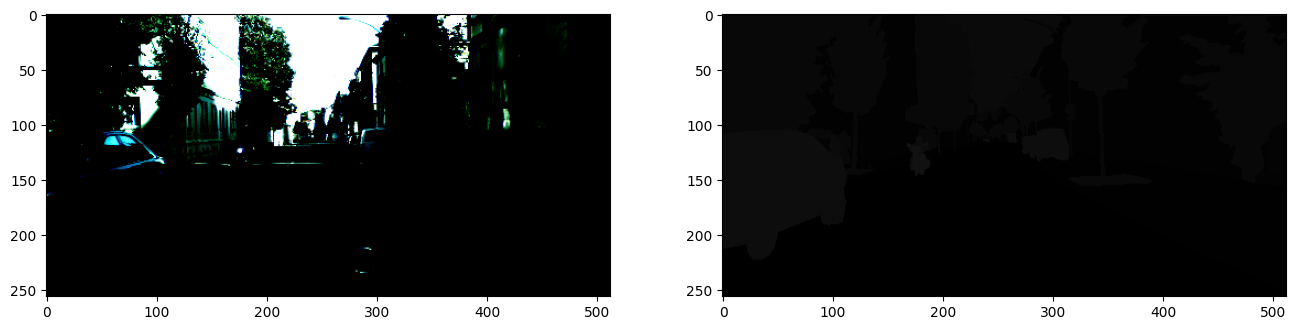

In [64]:
img, msk = train_dataset[1000]
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(16,8))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(msk,cmap='gray')

In [67]:
print(torch.unique(msk))
print(len(torch.unique(msk)))

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         17, 255], dtype=torch.uint8)
16


In [22]:
# res = modify_mask(msk.clone().numpy())  # Clone the mask and convert it to a NumPy array
# res_tensor = torch.from_numpy(res)  # Convert NumPy array to PyTorch tensor

# print(res_tensor.shape)
# print(torch.unique(res_tensor))
# print(len(torch.unique(res_tensor)))


In [68]:
#let do coloring
res=grayscale_to_rgb(msk)

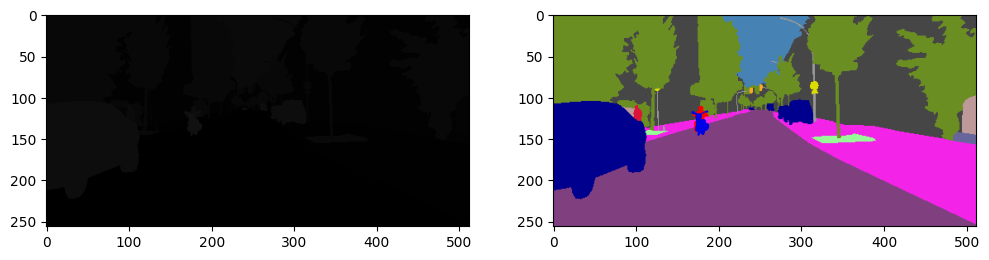

In [69]:
fig,ax=plt.subplots(ncols=2,figsize=(12,10))  
ax[0].imshow(msk,cmap='gray')
ax[1].imshow(res)

In [ ]:
import torch
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint
import segmentation_models_pytorch as smp

class OurModel(LightningModule):
    def __init__(self, n_classes):
        super(OurModel, self).__init__()
        self.model = smp.Unet("resnet34", classes=n_classes, activation=None)
        self.loss_fn = torch.nn.CrossEntropyLoss()  # Change as needed

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, masks = batch
        preds = self(images)
        loss = self.loss_fn(preds, masks)
        self.log('train_loss', loss)  # Log training loss
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        preds = self(images)
        loss = self.loss_fn(preds, masks)
        self.log('val_loss', loss)  # Log validation loss
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

# Initialize datasets and DataLoaders
train_dataset = CustomDataset(train_df_final, transform=transform)
val_dataset = CustomDataset(val_df_final, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Initialize model
n_classes = 20  # Update with your actual number of classes
model = OurModel(n_classes)

# Set up checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints',
    filename='file',
    save_last=True
)

# Initialize Trainer
trainer = Trainer(
    max_epochs=10,  # Set to 10 epochs
    precision='16-mixed',  # Use mixed precision
    callbacks=[checkpoint_callback],
)

# Start training
trainer.fit(model, train_loader, val_loader)




c:\Users\maina\miniconda3\Lib\site-packages\lightning_fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\maina\miniconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\maina\miniconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
